## Train

In [1]:
import argparse
import os
import logging
import sys
import itertools

import torch
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from vision.ssd.ssd import MatchPrior
from vision.ssd.vgg_ssd import create_vgg_ssd
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite
#
#from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.NEU_dataset import VOCDataset
#from vision.datasets.open_images import OpenImagesDataset
#
from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config import vgg_ssd_config
from vision.ssd.config import mobilenetv1_ssd_config
from vision.ssd.config import squeezenet_ssd_config
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform

print('Single Shot MultiBox Detector Training With Pytorch')

dataset_type = "voc"
datasets = "/home/taeho/다운로드/NEU-DET"
validation_dataset = "/home/taeho/다운로드/NEU-DET/test"
net = "vgg16-ssd"

# Params for SGD
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
base_net_lr = None
extra_layers_lr = None

# Params for loading pretrained basenet or checkpoints.
base_net = "models/vgg16_reducedfc.pth"
pretrained_ssd = None
resume = None

# Scheduler
scheduler = "multi-step"

# Params for Multi-step Scheduler
milestones = "120,160"

# Params for Cosine Annealing
t_max = 120.0

# Train params
batch_size = 24
num_epochs = 200
num_workers = 4
validation_epochs = 5
debug_steps = 100
use_cuda = True
checkpoint_folder = 'models/'

#
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")


def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps
            logging.info(
                f"Epoch: {epoch}, Step: {i}, " +
                f"Average Loss: {avg_loss:.4f}, " +
                f"Average Regression Loss {avg_reg_loss:.4f}, " +
                f"Average Classification Loss: {avg_clf_loss:.4f}"
            )
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0


def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num


#timer = Timer()
    
if net == 'vgg16-ssd':
    create_net = create_vgg_ssd
    config = vgg_ssd_config
else:
    print("No network")
    
        
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)

print("Prepare training datasets.")
datalist = []
if dataset_type == 'voc':
    dataset = VOCDataset(datasets, transform=train_transform,
                         target_transform=target_transform)
    label_file = os.path.join(checkpoint_folder, "neu-model-labels.txt")
    store_labels(label_file, dataset.class_names)
    num_classes = len(dataset.class_names)

else:
    print("No dataset_type")
    
datalist.append(dataset)
        
print("Stored labels into file neu-model-labels.txt.")
train_dataset = ConcatDataset(datalist)
print("Train dataset size: {}". format(len(train_dataset)))
train_loader = DataLoader(train_dataset, batch_size,
                          num_workers=num_workers,
                          shuffle=True)
    
print("Prepare Validation datasets.")
if dataset_type == "voc":
    val_dataset = VOCDataset(validation_dataset, transform=test_transform,
                             target_transform=target_transform, is_test=True)
        
print("validation dataset size: {}".format(len(val_dataset)))

val_loader = DataLoader(val_dataset, batch_size,
                        num_workers=num_workers,
                        shuffle=False)

print("Build network.")
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1

base_net_lr = base_net_lr if base_net_lr is not None else lr
extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    
params = [
    {'params': net.base_net.parameters(), 'lr': base_net_lr},
    {'params': itertools.chain(
        net.source_layer_add_ons.parameters(),
        net.extras.parameters()
    ), 'lr': extra_layers_lr},
    {'params': itertools.chain(
        net.regression_headers.parameters(),
        net.classification_headers.parameters()
    )}
]

#timer.start("Load Model")
if resume:
    print("Resume from the model")
    net.load(resume)
elif base_net:
    print("Init from base net")
    net.init_from_base_net(base_net)
elif pretrained_ssd:
    print("Init from pretrained ssd")
    net.init_from_pretrained_ssd(pretrained_ssd)
print()
#logging.info(f'Took {timer.end("Load Model"):.2f} seconds to load the model.')

net.to(DEVICE)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)
print("Learning rate:", lr, "Base net learning rate:", base_net_lr,
      "Extra Layers learning rate:", extra_layers_lr)

if scheduler == 'multi-step':
    print("Uses MultiStepLR scheduler.")
    milestones = [int(v.strip()) for v in milestones.split(",")]
    scheduler = MultiStepLR(optimizer, milestones=milestones,
                            gamma=0.1, last_epoch=last_epoch)
elif scheduler == 'cosine':
    print("Uses CosineAnnealingLR scheduler.")
    scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
else:
    print("Unsupported Scheduler")
    

print("Start training from epoch 0.")
for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)
        
    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        print("Epoch:", epoch, "\n", 
              "Validation Loss:", val_loss, "\n",
              "Validation Regression Loss:", val_regression_loss, "\n",
              "Validation Classification Loss:", val_classification_loss, "\n"
              )
        
        name = "vgg16-ssd" + "-Epoch-" + "%s"%epoch + "-Loss-" + "%s"%str(val_loss)[:7] + ".pth"
        model_path = os.path.join(checkpoint_folder, name)
        ##model_path = os.path.join(checkpoint_folder, f"{net}-Epoch-{epoch}-Loss-{val_loss}.pth")
        net.save(model_path)
        print("Saved model:", model_path)
        
        

Single Shot MultiBox Detector Training With Pytorch
Use Cuda.
Prepare training datasets.
Stored labels into file neu-model-labels.txt.
Train dataset size: 1439
Prepare Validation datasets.
validation dataset size: 360
Build network.
Init from base net

Learning rate: 0.001 Base net learning rate: 0.001 Extra Layers learning rate: 0.001
Uses MultiStepLR scheduler.
Start training from epoch 0.


/home/taeho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0 
 Validation Loss: 11.682182884216308 
 Validation Regression Loss: 2.961820634206136 
 Validation Classification Loss: 8.720362218221029 

Saved model: models/vgg16-ssd-Epoch-0-Loss-11.6821.pth
Epoch: 5 
 Validation Loss: 6.418720785776774 
 Validation Regression Loss: 2.687673584620158 
 Validation Classification Loss: 3.731047185262044 

Saved model: models/vgg16-ssd-Epoch-5-Loss-6.41872.pth
Epoch: 10 
 Validation Loss: 5.657911396026611 
 Validation Regression Loss: 2.417371884981791 
 Validation Classification Loss: 3.2405395189921062 

Saved model: models/vgg16-ssd-Epoch-10-Loss-5.65791.pth
Epoch: 15 
 Validation Loss: 5.085686111450196 
 Validation Regression Loss: 2.181206695238749 
 Validation Classification Loss: 2.904479455947876 

Saved model: models/vgg16-ssd-Epoch-15-Loss-5.08568.pth
Epoch: 20 
 Validation Loss: 4.616413052876791 
 Validation Regression Loss: 1.9347937424977621 
 Validation Classification Loss: 2.6816193262736 

Saved model: models/vgg16-ssd-Epoc

## Eval

In [9]:
import torch
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
#
#from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.NEU_dataset import VOCDataset
#from vision.datasets.open_images import OpenImagesDataset
#
from vision.utils import box_utils, measurements
from vision.utils.misc import str2bool, Timer
import argparse
import pathlib
import numpy as np
import logging
import sys
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite, create_mobilenetv2_ssd_lite_predictor



print("SSD Evaluation on NEU Dataset.")
net = "vgg16-ssd"
trained_model = "models/vgg16-ssd-Epoch-165-Loss-3.22347.pth"
dataset_type = "voc"
dataset = "/home/taeho/다운로드/NEU-DET/test"
label_file = "models/neu-model-labels.txt"
use_cuda = True
use_2007_metric = True
nms_method = "hard"
iou_threshold = 0.5
eval_dir = "eval_results"
#mb2_width_mult = 1.0


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")


def group_annotation_by_class(dataset):
    true_case_stat = {}
    all_gt_boxes = {}
    all_difficult_cases = {}
    for i in range(len(dataset)):
        image_id, annotation = dataset.get_annotation(i)
        gt_boxes, classes, is_difficult = annotation
        gt_boxes = torch.from_numpy(gt_boxes)
        for i, difficult in enumerate(is_difficult):
            class_index = int(classes[i])
            gt_box = gt_boxes[i]
            if not difficult:
                true_case_stat[class_index] = true_case_stat.get(class_index, 0) + 1

            if class_index not in all_gt_boxes:
                all_gt_boxes[class_index] = {}
            if image_id not in all_gt_boxes[class_index]:
                all_gt_boxes[class_index][image_id] = []
            all_gt_boxes[class_index][image_id].append(gt_box)
            if class_index not in all_difficult_cases:
                all_difficult_cases[class_index]={}
            if image_id not in all_difficult_cases[class_index]:
                all_difficult_cases[class_index][image_id] = []
            all_difficult_cases[class_index][image_id].append(difficult)

    for class_index in all_gt_boxes:
        for image_id in all_gt_boxes[class_index]:
            all_gt_boxes[class_index][image_id] = torch.stack(all_gt_boxes[class_index][image_id])
    for class_index in all_difficult_cases:
        for image_id in all_difficult_cases[class_index]:
            all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])
    return true_case_stat, all_gt_boxes, all_difficult_cases


def compute_average_precision_per_class(num_true_cases, gt_boxes, difficult_cases,
                                        prediction_file, iou_threshold, use_2007_metric):
    with open(prediction_file) as f:
        image_ids = []
        boxes = []
        scores = []
        for line in f:
            t = line.rstrip().split(" ")
            image_ids.append(t[0])
            scores.append(float(t[1]))
            box = torch.tensor([float(v) for v in t[2:]]).unsqueeze(0)
            box -= 1.0  # convert to python format where indexes start from 0
            boxes.append(box)
        scores = np.array(scores)
        sorted_indexes = np.argsort(-scores)
        boxes = [boxes[i] for i in sorted_indexes]
        image_ids = [image_ids[i] for i in sorted_indexes]
        true_positive = np.zeros(len(image_ids))
        false_positive = np.zeros(len(image_ids))
        matched = set()
        for i, image_id in enumerate(image_ids):
            box = boxes[i]
            if image_id not in gt_boxes:
                false_positive[i] = 1
                continue

            gt_box = gt_boxes[image_id]
            ious = box_utils.iou_of(box, gt_box)
            max_iou = torch.max(ious).item()
            max_arg = torch.argmax(ious).item()
            if max_iou > iou_threshold:
                if difficult_cases[image_id][max_arg] == 0:
                    if (image_id, max_arg) not in matched:
                        true_positive[i] = 1
                        matched.add((image_id, max_arg))
                    else:
                        false_positive[i] = 1
            else:
                false_positive[i] = 1

    true_positive = true_positive.cumsum()
    false_positive = false_positive.cumsum()
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / num_true_cases
    if use_2007_metric:
        return measurements.compute_voc2007_average_precision(precision, recall)
    else:
        return measurements.compute_average_precision(precision, recall)


if __name__ == '__main__':
    eval_path = pathlib.Path(eval_dir)
    eval_path.mkdir(exist_ok=True)
    timer = Timer()
    class_names = [name.strip() for name in open(label_file).readlines()]

    if dataset_type == "voc":
        dataset = VOCDataset(dataset, is_test=True)
    else:
        print("No dataset_type")

    true_case_stat, all_gb_boxes, all_difficult_cases = group_annotation_by_class(dataset)
    
    if net == 'vgg16-ssd':
        net = create_vgg_ssd(len(class_names), is_test=True)
        predictor = create_vgg_ssd_predictor(net, nms_method=nms_method, device=DEVICE)
    else:
        print("No net type")

    timer.start("Load Model")
    net.load(trained_model)
    net = net.to(DEVICE)
    print(f'It took {timer.end("Load Model")} seconds to load the model.')
          
   

    results = []
    for i in range(len(dataset)):
        if i == 0 or i == (len(dataset)-1):
            print("process image", i)
        #timer.start("Load Image")
        image = dataset.get_image(i)
        #print("Load Image: {:4f} seconds.".format(timer.end("Load Image")))
        #timer.start("Predict")
        boxes, labels, probs = predictor.predict(image)
        #print("Prediction: {:4f} seconds.".format(timer.end("Predict")))
        indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
        results.append(torch.cat([
            indexes.reshape(-1, 1),
            labels.reshape(-1, 1).float(),
            probs.reshape(-1, 1),
            boxes + 1.0  # matlab's indexes start from 1
        ], dim=1))
    results = torch.cat(results)
    for class_index, class_name in enumerate(class_names):
        if class_index == 0: continue  # ignore background
        prediction_path = eval_path / f"det_test_{class_name}.txt"
        with open(prediction_path, "w") as f:
            sub = results[results[:, 1] == class_index, :]
            for i in range(sub.size(0)):
                prob_box = sub[i, 2:].numpy()
                image_id = dataset.ids[int(sub[i, 0])]
                print(
                    image_id + " " + " ".join([str(v) for v in prob_box]),
                    file=f
                    )
          
          
    aps = []
    print("\n\nAverage Precision Per-class:")
    for class_index, class_name in enumerate(class_names):
        if class_index == 0:
            continue
        prediction_path = eval_path / f"det_test_{class_name}.txt"
        ap = compute_average_precision_per_class(
            true_case_stat[class_index],
            all_gb_boxes[class_index],
            all_difficult_cases[class_index],
            prediction_path,
            iou_threshold,
            use_2007_metric
        )
        aps.append(ap)
        print(f"{class_name}: {ap}")

    print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")


SSD Evaluation on NEU Dataset.


/home/taeho/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


It took 0.056073665618896484 seconds to load the model.
process image 0
Inference time:  0.003026723861694336
Inference time:  0.002904653549194336
Inference time:  0.0027892589569091797
Inference time:  0.002863645553588867
Inference time:  0.002885103225708008
Inference time:  0.0030956268310546875
Inference time:  0.0028891563415527344
Inference time:  0.002798795700073242
Inference time:  0.002779722213745117
Inference time:  0.002790689468383789
Inference time:  0.0032126903533935547
Inference time:  0.003064393997192383
Inference time:  0.0029108524322509766
Inference time:  0.0029108524322509766
Inference time:  0.0028526782989501953
Inference time:  0.003162384033203125
Inference time:  0.002924680709838867
Inference time:  0.0028765201568603516
Inference time:  0.002892732620239258
Inference time:  0.0028641223907470703
Inference time:  0.0028548240661621094
Inference time:  0.0029397010803222656
Inference time:  0.002837657928466797
Inference time:  0.0028333663940429688
Infe

## Visualize

Inference time:  0.0030248165130615234
Found 2 objects. The output image is run_ssd_example_output.jpg


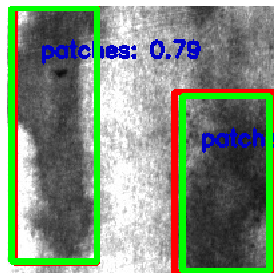

Inference time:  0.003600597381591797
Found 3 objects. The output image is run_ssd_example_output.jpg


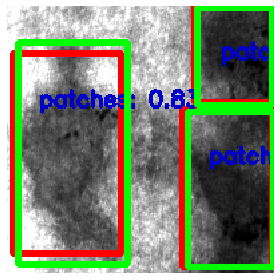

Inference time:  0.003545522689819336
Found 3 objects. The output image is run_ssd_example_output.jpg


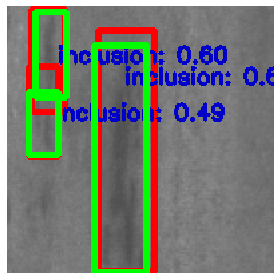

In [10]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite, create_mobilenetv2_ssd_lite_predictor
from vision.utils.misc import Timer
import cv2
import sys

import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
%matplotlib inline

net_type = "vgg16-ssd"
model_path = "models/vgg16-ssd-Epoch-165-Loss-3.22347.pth"
label_path = "models/neu-model-labels.txt"
#image_path = "data/patches_294.jpg"

class_names = [name.strip() for name in open(label_path).readlines()]

if net_type == 'vgg16-ssd':
    net = create_vgg_ssd(len(class_names), is_test=True)
    predictor = create_vgg_ssd_predictor(net, candidate_size=200)
    
else:
    print("The net type is wrong.")
    
net.load(model_path)


def image_print(image_path):
    orig_image = cv2.imread(image_path)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    boxes, labels, probs = predictor.predict(image, 10, 0.4)


    for i in range(boxes.size(0)):
        box = boxes[i, :]
        cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 4)
        #label = f"""{voc_dataset.class_names[labels[i]]}: {probs[i]:.2f}"""
        #label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
        label = str(class_names[labels[i]]) + ": " + str(probs[i])[-7:-3]

        cv2.putText(orig_image, label,
                    (box[0] + 20, box[1] + 40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.55,  # font scale
                    (200, 0, 0),
                    2)  # line type
    ###
    xml_path = "/home/taeho/다운로드/NEU-DET/ANNOTATIONS/"
    xmin = []
    ymin = []
    xmax = []
    ymax = []

    a = image_path.split('/')
    b = a[1].split('.')
    xml = b[0] + ".xml"

    tree = ET.parse(xml_path + xml)
    root = tree.getroot()

    for child in root.iter():
        tag = child.tag
        if tag == "xmin":
            xmin.append(int(child.text))
        if tag == "ymin":
            ymin.append(int(child.text))
        if tag == "xmax":
            xmax.append(int(child.text))
        if tag == "ymax":
            ymax.append(int(child.text))

    for i, num in enumerate(xmin):
        cv2.rectangle(orig_image, (xmin[i], ymin[i]), (xmax[i], ymax[i]), (0, 255, 0), 4)

    ###
    path = "run_ssd_example_output.jpg"
    ##cv2.imwrite(path, orig_image)
    print(f"Found {len(probs)} objects. The output image is {path}")

    img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(img)
    plt.show()
    
image_print("data/patches_294.jpg")
image_print("data/patches_297.jpg")
image_print("data/inclusion_40.jpg")